In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import missingno as msno
import seaborn as sns

In [2]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (20, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [3]:
# afficher les dataframes complets
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
# on peut préciser les types de données direct dans le read csv
init_products = pd.read_csv('products.csv', sep='\t', low_memory=False)

In [5]:
# entre les parenthèses, shift tab pour afficher les params de la fction
# on peut également faire products.info?
raw_products = init_products.copy()
raw_products.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1486047 entries, 0 to 1486046
Data columns (total 182 columns):
 #   Column                                      Dtype  
---  ------                                      -----  
 0   code                                        object 
 1   url                                         object 
 2   creator                                     object 
 3   created_t                                   int64  
 4   created_datetime                            object 
 5   last_modified_t                             int64  
 6   last_modified_datetime                      object 
 7   product_name                                object 
 8   generic_name                                object 
 9   quantity                                    object 
 10  packaging                                   object 
 11  packaging_tags                              object 
 12  packaging_text                              object 
 13  brands                    

Différentes obervations :
- les dimensions du dataframe 1486047 x 182
- les colonnes sont de 3 types différents: int64, float64 ou object
- les deux colonnes int64 ont un nom qui termine par \_t et sont des timestamps
- la colonne d'indice 171 contient des objects mais devrait à priori contenir des float64 (\_100g)
- on observe que certaines colonnes ont des types plus ou moins cohérents (ex allergen_en est un float alors que allergen est un object et traces_en aussi un object)
- les colonnes qui commençent par '-' se déclinent de la précédente

In [6]:
# on converti les deux colonnes _t en datetime, ainsi que les deux colonnes _datetime
products = raw_products.copy()
products['created_t'] = pd.to_datetime(products['created_t'], unit='s', utc=True)
products['created_datetime'] = pd.to_datetime(products['created_datetime'], unit='ns', utc=True)
products['last_modified_t'] = pd.to_datetime(products['last_modified_t'], unit='s', utc=True)
products['last_modified_datetime'] = pd.to_datetime(products['last_modified_datetime'], unit='ns', utc=True)
products.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1486047 entries, 0 to 1486046
Data columns (total 182 columns):
 #   Column                                      Dtype              
---  ------                                      -----              
 0   code                                        object             
 1   url                                         object             
 2   creator                                     object             
 3   created_t                                   datetime64[ns, UTC]
 4   created_datetime                            datetime64[ns, UTC]
 5   last_modified_t                             datetime64[ns, UTC]
 6   last_modified_datetime                      datetime64[ns, UTC]
 7   product_name                                object             
 8   generic_name                                object             
 9   quantity                                    object             
 10  packaging                                   object   

In [7]:
products.isna().any()

code                                          False
url                                           False
creator                                        True
created_t                                     False
created_datetime                              False
last_modified_t                               False
last_modified_datetime                        False
product_name                                   True
generic_name                                   True
quantity                                       True
packaging                                      True
packaging_tags                                 True
packaging_text                                 True
brands                                         True
brands_tags                                    True
categories                                     True
categories_tags                                True
categories_en                                  True
origins                                        True
origins_tags

il existe des na dans presques toutes les colonnes sauf:
code
url
created_t
created_datetime                              
last_modified_t                               
last_modified_datetime                        
states                                        
states_tags                                   
states_en

il s'agit probablement des métadonnées: création modification et état de la donnée en base de données

on retire les colonnes qui commençent par '-', qui sont des données très précises déclinées de la colonne précédente

In [8]:
startw = products.columns.str.startswith('-')

In [9]:
products = products.iloc[:,~startw]
products.shape

(1486047, 147)

on détermine le % de na par colonne

In [10]:
naproducts = products.isna()

In [11]:
napercent = 100*( 1-(naproducts.sum()/len(naproducts)) )
napercent = napercent.astype(np.int64)
#napercent = 10*napercent
# on peut faire un bar chart pour afficher ces %

In [12]:
napercent

code                                          100
url                                           100
creator                                        99
created_t                                     100
created_datetime                              100
last_modified_t                               100
last_modified_datetime                        100
product_name                                   95
generic_name                                    7
quantity                                       27
packaging                                      15
packaging_tags                                 15
packaging_text                                  0
brands                                         55
brands_tags                                    55
categories                                     50
categories_tags                                50
categories_en                                  50
origins                                         4
origins_tags                                    4


Text(0, 0.5, '% de complétude')

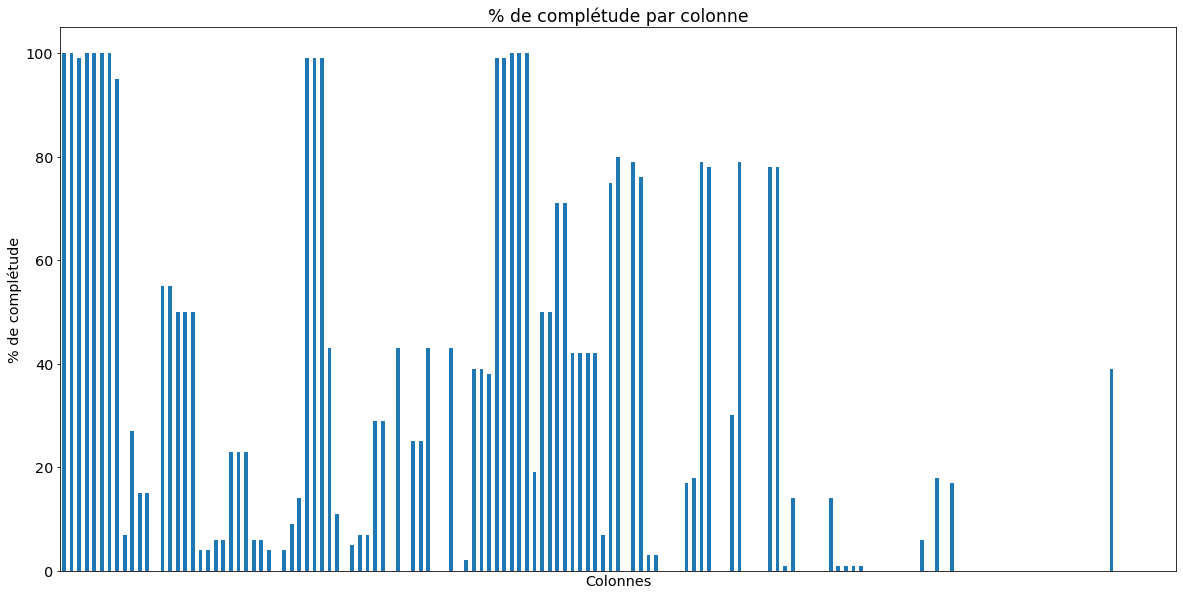

In [13]:
napercent.plot(kind='bar')
plt.title('% de complétude par colonne')
plt.xticks([]) 
plt.xlabel('Colonnes')
plt.ylabel('% de complétude')

In [14]:
# On peut réaficher avec moins de colonne, regarder quelles colonnes je supprime
# package python s'appelle missing no
# https://github.com/ResidentMario/missingno

# décrire la donnée par groupe de colonne type metadonnée, composition etc

on observe qu'environ 15 % des échantillons sont quasi complets (90-100% de na)
on décide de conserver les colonnes des échantillons complets à +10%

In [15]:
products_del = products[napercent[napercent <= 10].index]
products = products[napercent[napercent > 10].index]


Text(0.5, 1.0, 'Exemple de la fréquence de données manquantes parmi les colonnes supprimées')

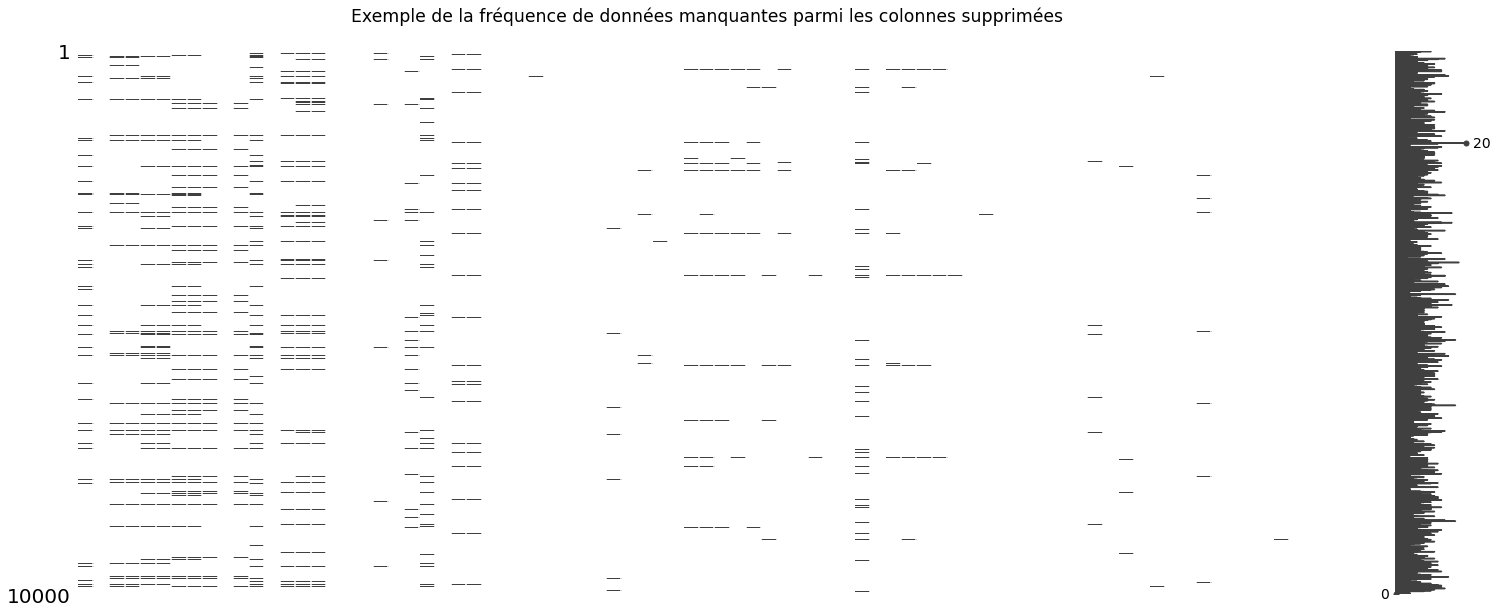

In [16]:
# on prend juste un sample car sinon freeze
msno.matrix(products_del.sample(10000))
plt.title('Exemple de la fréquence de données manquantes parmi les colonnes supprimées', pad=30)

In [17]:
products_del.columns

Index(['generic_name', 'packaging_text', 'origins', 'origins_tags',
       'manufacturing_places', 'manufacturing_places_tags', 'emb_codes',
       'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags',
       'purchase_places', 'allergens_en', 'traces', 'traces_tags', 'traces_en',
       'no_nutriments', 'additives', 'ingredients_from_palm_oil',
       'ingredients_from_palm_oil_tags',
       'ingredients_that_may_be_from_palm_oil',
       'ingredients_that_may_be_from_palm_oil_tags', 'energy-kj_100g',
       'energy-from-fat_100g', 'monounsaturated-fat_100g',
       'polyunsaturated-fat_100g', 'omega-3-fat_100g', 'omega-6-fat_100g',
       'omega-9-fat_100g', 'starch_100g', 'polyols_100g', 'casein_100g',
       'serum-proteins_100g', 'nucleotides_100g', 'alcohol_100g',
       'beta-carotene_100g', 'vitamin-d_100g', 'vitamin-e_100g',
       'vitamin-k_100g', 'vitamin-b1_100g', 'vitamin-b2_100g',
       'vitamin-pp_100g', 'vitamin-b6_100g', 'vitamin-b9_100g', 'folates_1

In [18]:
products.code.value_counts().head(10)

3454681006511    2
3760275520791    2
3261830123377    2
5690522007516    2
8585002525024    1
3349010003340    1
0637480045681    1
8437009075203    1
4901330300555    1
5410216034334    1
Name: code, dtype: int64

In [19]:
unique_prod = products.drop_duplicates('code')
# ne pes hésiter à créer des nouveaux df 

In [20]:
testdf = unique_prod.copy()

In [21]:
len(testdf)

1486043

In [22]:
print(testdf.at[267155, 'countries_en'])
print(testdf.at[958970, 'countries_en'])


France
France,Germany


In [23]:
testdf['countries_en'] = testdf['countries_en'].str.split(',')

In [24]:
print(testdf.at[267155, 'countries_en'])
print(testdf.at[958970, 'countries_en'])

['France']
['France', 'Germany']


In [25]:
len(testdf)

1486043

In [26]:
df_explode = unique_prod.copy()
df_explode['countries_en'] = df_explode['countries_en'].str.split(',')
df_explode = df_explode.explode('countries_en')

In [27]:
len(df_explode)

1592779

In [28]:
print(df_explode.at[267155, 'countries_en'])
print(df_explode.at[958970, 'countries_en'])

France
['France' 'Germany']


on remarque que la colonne countries_en est plus facilement exploitable

In [29]:
df_explode['countries_en'].value_counts().head(30)

France            721685
United States     337042
Spain             182370
Germany            63903
Belgium            52812
Switzerland        51869
United Kingdom     30434
Canada             18080
Italy              13225
Ireland             8629
Netherlands         7711
Australia           7258
Mexico              5599
Austria             5126
Poland              4611
Portugal            3692
Sweden              3509
Morocco             3223
Russia              3092
Luxembourg          2928
Thailand            2903
Réunion             2407
Romania             1871
Finland             1846
Hungary             1768
Brazil              1720
Algeria             1660
Argentina           1650
Czech Republic      1575
Bulgaria            1572
Name: countries_en, dtype: int64

Text(0.5, 1.0, 'Nombre de produits pour les 10 pays les plus représentés')

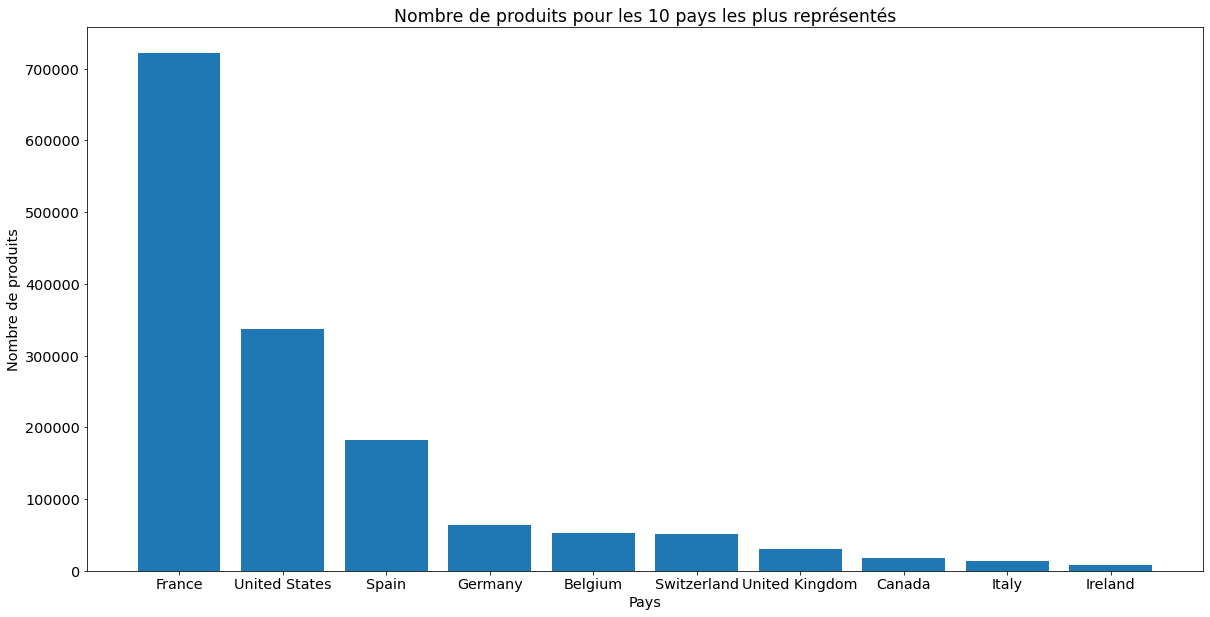

In [30]:
top10 = df_explode['countries_en'].value_counts().head(10)
fig = plt.figure()
plt.bar(top10.index, top10.values)
plt.ylabel('Nombre de produits')
plt.xlabel('Pays')
plt.title('Nombre de produits pour les 10 pays les plus représentés')


On focus l'étude sur les 3 premiers pays (qui contiennent plus de 100 000 produits chacun)
On décide de s'intéresser aux catégories
Refaire rapidement létude pour categories en

In [31]:
# comment faire pour choisir par ex les 10 payes qui contiennent le plus de produit ...?
# comment faire pour travailler avec les groupby et ne choisir ensuite que certaines valeurs
top_countries = df_explode['countries_en'].value_counts().index[:3]
cat_prod = df_explode[df_explode['countries_en'].isin(top_countries) ].dropna(subset=['categories_en'])


# == > < sont surchargés dans ce cas

In [32]:
len(cat_prod)

670868

In [33]:
cat_prod.categories_en.value_counts().head(10)

Snacks                                                                                               33062
Snacks,Sweet snacks,Confectioneries                                                                  15408
Groceries,Sauces                                                                                     15128
Dairies,Fermented foods,Fermented milk products,Cheeses                                              13066
Snacks,Sweet snacks,Biscuits and cakes,Biscuits                                                      12937
Desserts,Frozen foods,Frozen desserts                                                                 9218
Beverages                                                                                             8229
Plant-based foods and beverages,Plant-based foods,Cereals and potatoes,Breads                         7986
Plant-based foods and beverages,Plant-based foods,Cereals and potatoes,Cereals and their products     7294
Frozen foods                         

In [34]:
cat_prod.categories_en = cat_prod.categories_en.str.split(',')
cat_explode = cat_prod.explode('categories_en')

In [35]:
len(cat_explode)

3109369

In [36]:
cat_explode.categories_en.value_counts().head(10)

Plant-based foods and beverages      184148
Plant-based foods                    158385
Snacks                               129980
Sweet snacks                          83031
Beverages                             77039
Dairies                               62199
Cereals and potatoes                  57434
Fruits and vegetables based foods     53273
Groceries                             53233
Meats                                 49431
Name: categories_en, dtype: int64

Text(0.5, 1.0, 'Nombre de produits pour les 10 catégories les plus représentées')

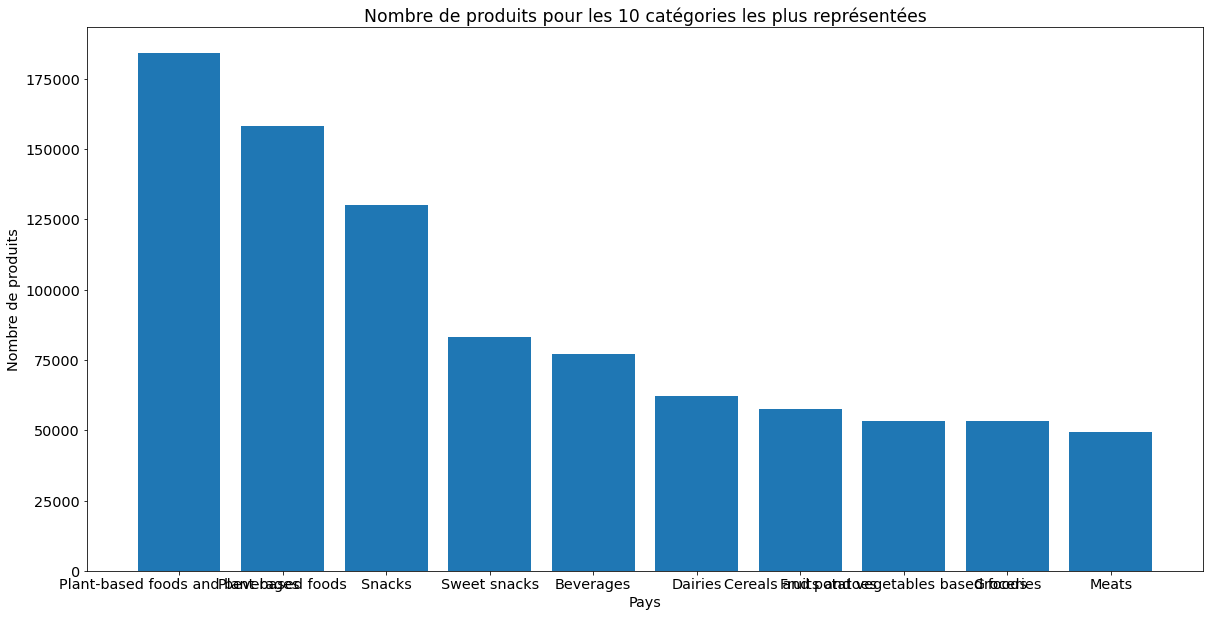

In [37]:
top10_cat = cat_explode.categories_en.value_counts().head(10)
fig = plt.figure()
plt.bar(top10_cat.index, top10_cat.values)
plt.ylabel('Nombre de produits')
plt.xlabel('Pays')
plt.title('Nombre de produits pour les 10 catégories les plus représentées')

On souhaite comparer les nutriscores en fction des pays

In [38]:
nutri_full = cat_explode.dropna(subset=['nutriscore_score'])

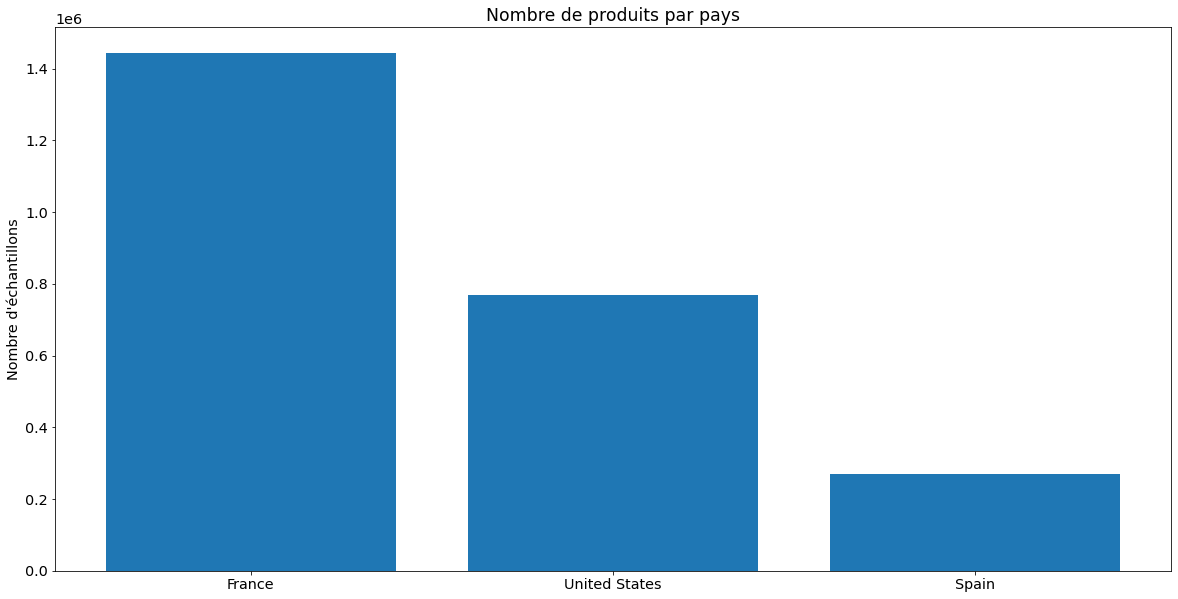

In [39]:
#plt.figure()
nb_prod_countries = [len(nutri_full[nutri_full.countries_en == country]) for country in top_countries]
plt.figure()
plt.title('Nombre de produits par pays')
plt.bar(top_countries, nb_prod_countries)
plt.ylabel('Nombre d\'échantillons')
plt.show()

In [40]:
nb_prod_countries

[1443263, 768046, 270870]

In [41]:
min_sample = min(nutri_full.countries_en.value_counts())

In [42]:
min_sample

270870

L'Espagne possède le minimum de produits dans cette catégorie parmi nos 3 pays. On décide de prévlever 
un échantillon de cette taille également pour les deux autres pays

In [43]:
sample_prod = []
for country in top_countries:
    df_temp = nutri_full[nutri_full.countries_en == country].sample(min_sample).copy()
    sample_prod.append(df_temp)
sample_prod = pd.concat(sample_prod)

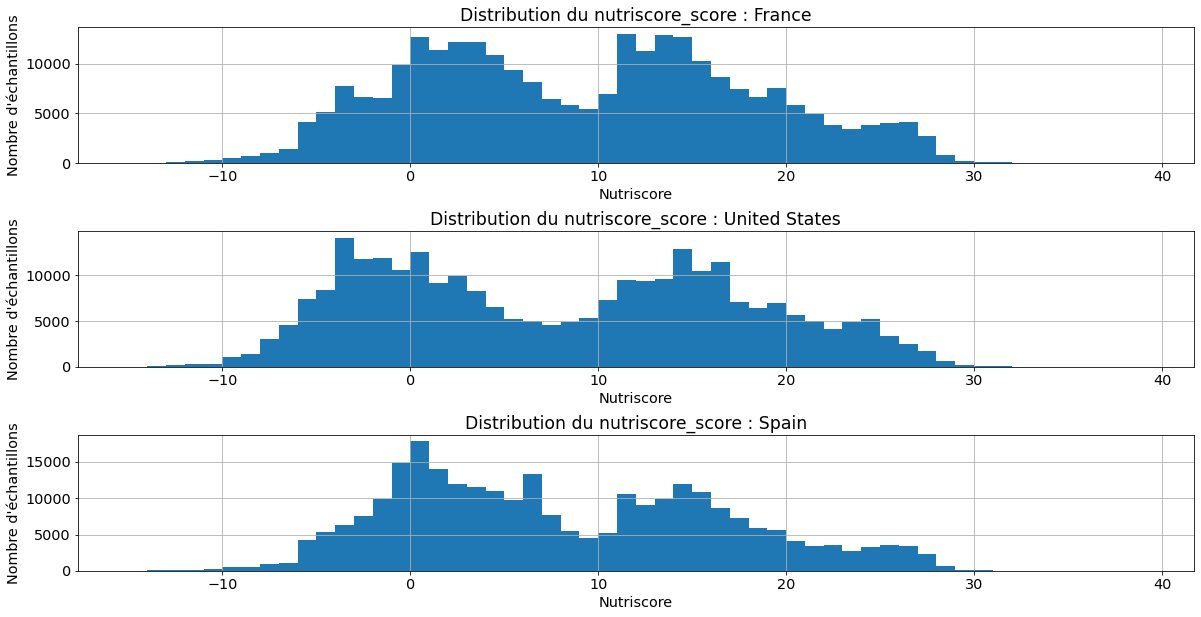

In [44]:
#plant.hist(column='nutriscore_score', by='countries_en', figsize=[20,10], bins=50)
plt.figure()
for idx, country in enumerate(list(sample_prod.countries_en.unique())):
    plt.subplot(3,1,idx+1)
    sample_prod[sample_prod.countries_en == country]['nutriscore_score'].hist(bins=[i for i in range(-15, 40)])
    plt.title('Distribution du nutriscore_score : '+country)
    plt.xlabel('Nutriscore')
    plt.ylabel('Nombre d\'échantillons')
    plt.subplots_adjust(hspace = 0.5)

plt.show()

On observe qu'il existe une autre façon de classer un produit en fonction du nutriscore : le nutriscore_grade.

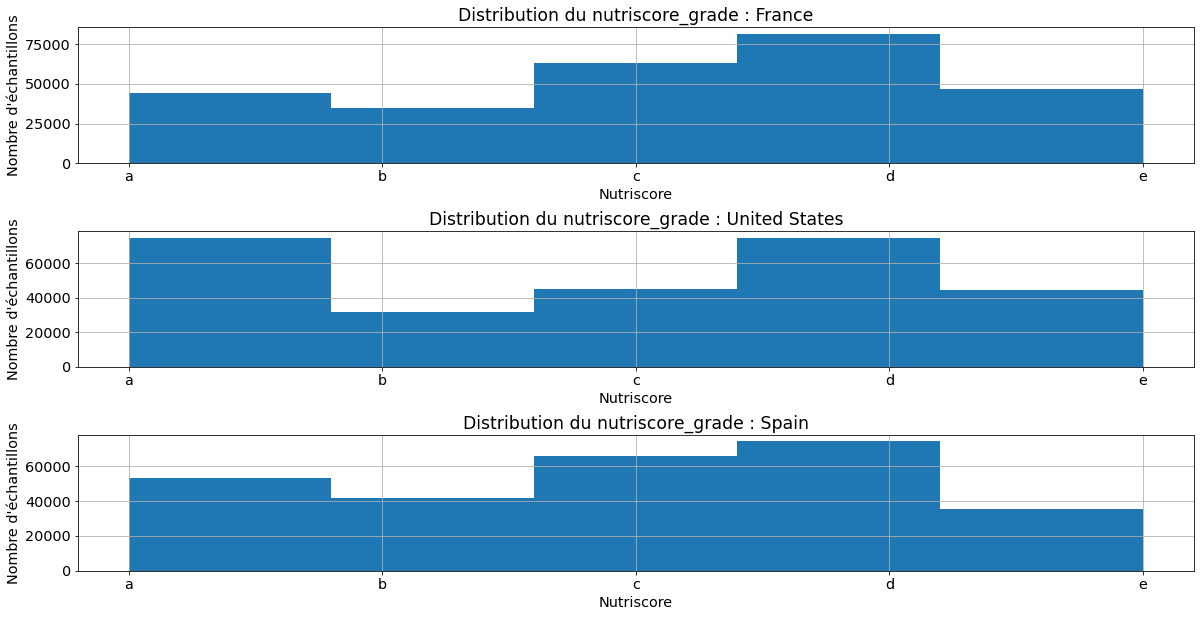

In [45]:
plt.figure()
for idx, country in enumerate(list(sample_prod.countries_en.unique())):
    plt.subplot(3,1,idx+1)
    sample_prod[sample_prod.countries_en == country]['nutriscore_grade'].sort_values().hist(bins=5)
    plt.title('Distribution du nutriscore_grade : '+country)
    plt.xlabel('Nutriscore')
    plt.ylabel('Nombre d\'échantillons')
    plt.subplots_adjust(hspace = 0.5)

plt.show()

In [46]:
sample_prod[['nutriscore_score', 'nutriscore_grade']].corr()

,nutriscore_score
nutriscore_score,1.0


On observe sans surprise que la corrélation est totale entre ces deux paramètres du nutriscore, ce sont deux représentations
différentes de ce dernier.

In [47]:
for country in top_countries:
    subset = sample_prod[sample_prod.countries_en == country] # Création du sous-échantillon
    print(country)
    print("moy:",subset.nutriscore_score.mean())
    print("med:",subset.nutriscore_score.median())
    print("mod:",subset.nutriscore_score.mode())
    print("var:",subset.nutriscore_score.var(ddof=0))
    print("ect:",subset.nutriscore_score.std(ddof=0))
    print("skw:",subset.nutriscore_score.skew())
    print("kur:",subset.nutriscore_score.kurtosis())
    print("\n")

France
moy: 8.749237641673128
med: 9.0
mod: 0    11.0
dtype: float64
var: 78.03438999360282
ect: 8.83370760177191
skw: 0.15136994493581238
kur: -0.857115842642302


United States
moy: 7.477247388045926
med: 7.0
mod: 0   -4.0
dtype: float64
var: 93.6227019442912
ect: 9.675882489173336
skw: 0.15076797214153273
kur: -1.1186913107403098


Spain
moy: 7.6327389522649245
med: 6.0
mod: 0    0.0
dtype: float64
var: 74.47967981309587
ect: 8.630161053717124
skw: 0.36360321784020194
kur: -0.7527324382753444




On observe un pic de nutricore 6 en Espagne

In [48]:
esp_test = sample_prod[sample_prod.countries_en == 'Spain']
esp_test[esp_test.nutriscore_score == 6].main_category_en.value_counts().head(10)

Extra-virgin olive oils    5080
Virgin olive oils          1389
Olive oils                 1036
Fruit-jams                  647
Dried apricots              152
Sweetened beverages         123
Breakfast cereals           120
Greek yogurts               107
Fried tomato sauces          84
Multifruit juices            84
Name: main_category_en, dtype: int64

In [49]:
perc_oil = sum(esp_test[esp_test.nutriscore_score == 6].main_category_en.str.contains('oil'))/len(esp_test[esp_test.nutriscore_score == 6])

In [50]:
perc_oil

0.5659348864994026

On remarque que le groupe de produit espagnol pour lequel le nutriscore est de 6, le mode, est composé à plus de 65% d'huile
d'olive, ce qui semble logique pour l'espagne. Si on retranche graphiquement ces 65%, la somme des nutriscores égaux à 6
correspond bien à la distrivution observée. Le mode deviendrait alors -1 comme attendu.

In [51]:
us_test = sample_prod[sample_prod.countries_en == 'United States']
us_test[us_test.nutriscore_score == -4].main_category_en.value_counts().head(10)

Pastas                        3383
Canned vegetables             1840
Canned fruits                 1098
Tomatoes                      1047
Canned common beans            988
Cereals and their products     472
Spaghetti                      367
Noodles                        279
Fruits based foods             272
Frozen seafood                 267
Name: main_category_en, dtype: int64

Même remarque pour les pâtes sur le -4 aux US

On approfondi l'étude en calculant sa corrélation avec les autres paramètres numériques

In [52]:
corr_test_nutri = cat_explode.corr().nutriscore_score.sort_values()
corr_test_nutri

fiber_100g                                -0.184411
serving_quantity                          -0.016502
vitamin-c_100g                            -0.011552
iron_100g                                 -0.001566
saturated-fat_100g                         0.001781
vitamin-a_100g                             0.005209
calcium_100g                               0.013201
cholesterol_100g                           0.021260
trans-fat_100g                             0.025579
sodium_100g                                0.045351
salt_100g                                  0.045368
ingredients_that_may_be_from_palm_oil_n    0.125768
proteins_100g                              0.132615
ingredients_from_palm_oil_n                0.156494
carbohydrates_100g                         0.222123
additives_n                                0.276231
energy-kcal_100g                           0.293316
sugars_100g                                0.415252
nova_group                                 0.427588
fat_100g    

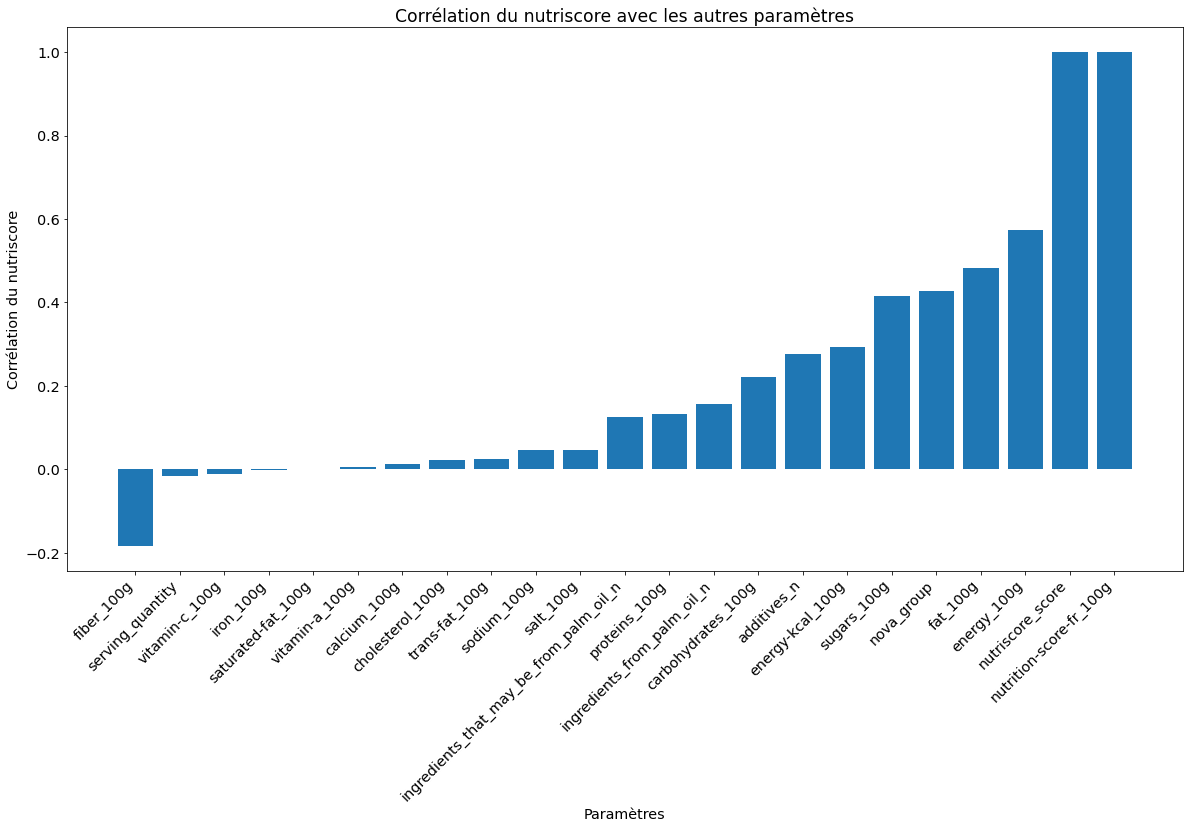

In [53]:
fig = plt.figure()
plt.bar(corr_test_nutri.index, corr_test_nutri.values)
plt.title('Corrélation du nutriscore avec les autres paramètres')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Corrélation du nutriscore')
plt.xlabel('Paramètres')
plt.show()

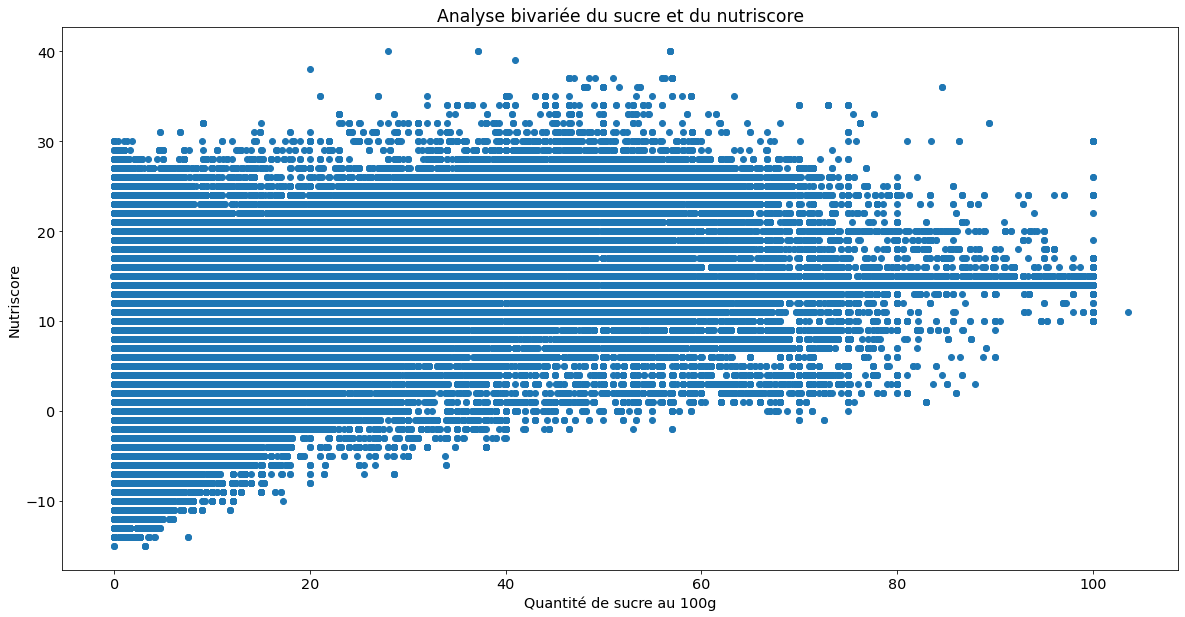

In [54]:
fig = plt.figure()
plt.scatter(sample_prod.sugars_100g, sample_prod.nutriscore_score)
plt.title('Analyse bivariée du sucre et du nutriscore')
plt.ylabel('Nutriscore')
plt.xlabel('Quantité de sucre au 100g')
plt.show()

In [55]:
from matplotlib.collections import LineCollection


def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

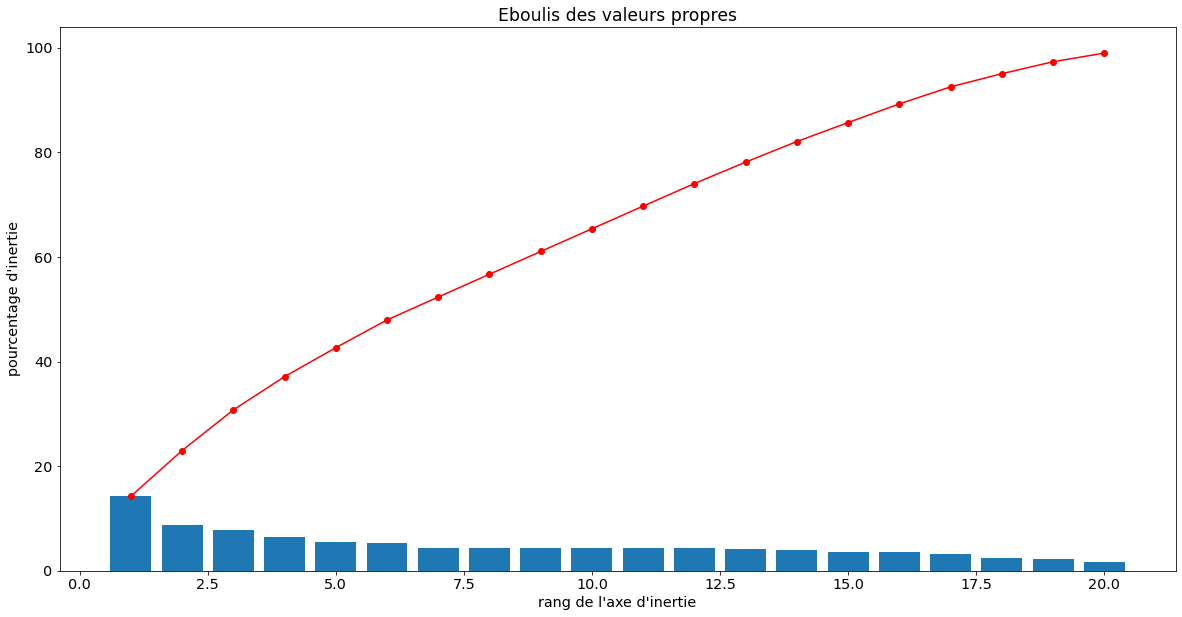

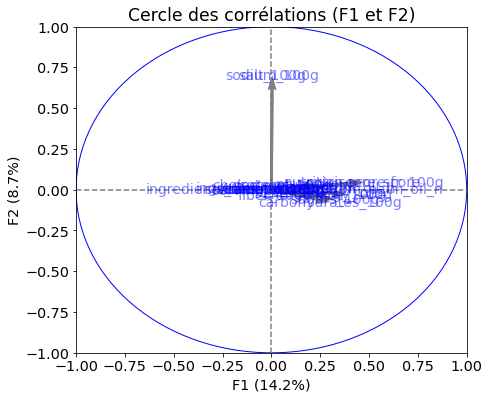

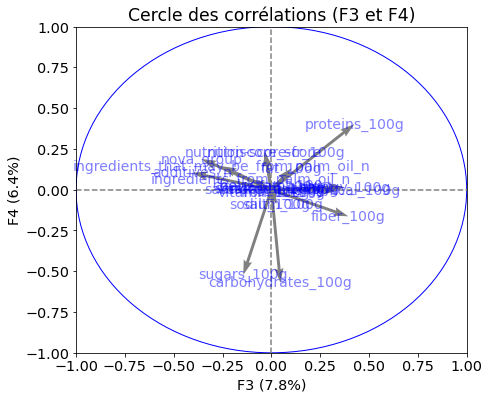

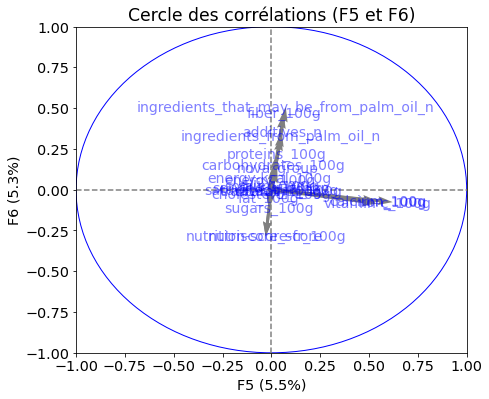

In [59]:
from sklearn import decomposition
from sklearn import preprocessing

# choix du nombre de composantes à calculer
n_comp = 20

# selection des colonnes à prendre en compte dans l'ACP
data_pca = cat_explode[corr_test_nutri.index]

# préparation des données pour l'ACP
data_pca = data_pca.fillna(data_pca.mean()) # Il est fréquent de remplacer les valeurs inconnues par la moyenne de la variable
X = data_pca.values
features = data_pca.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))



plt.show()

Text(0.5, 1.0, 'Projection des paramètres sur la première composante de la PCA')

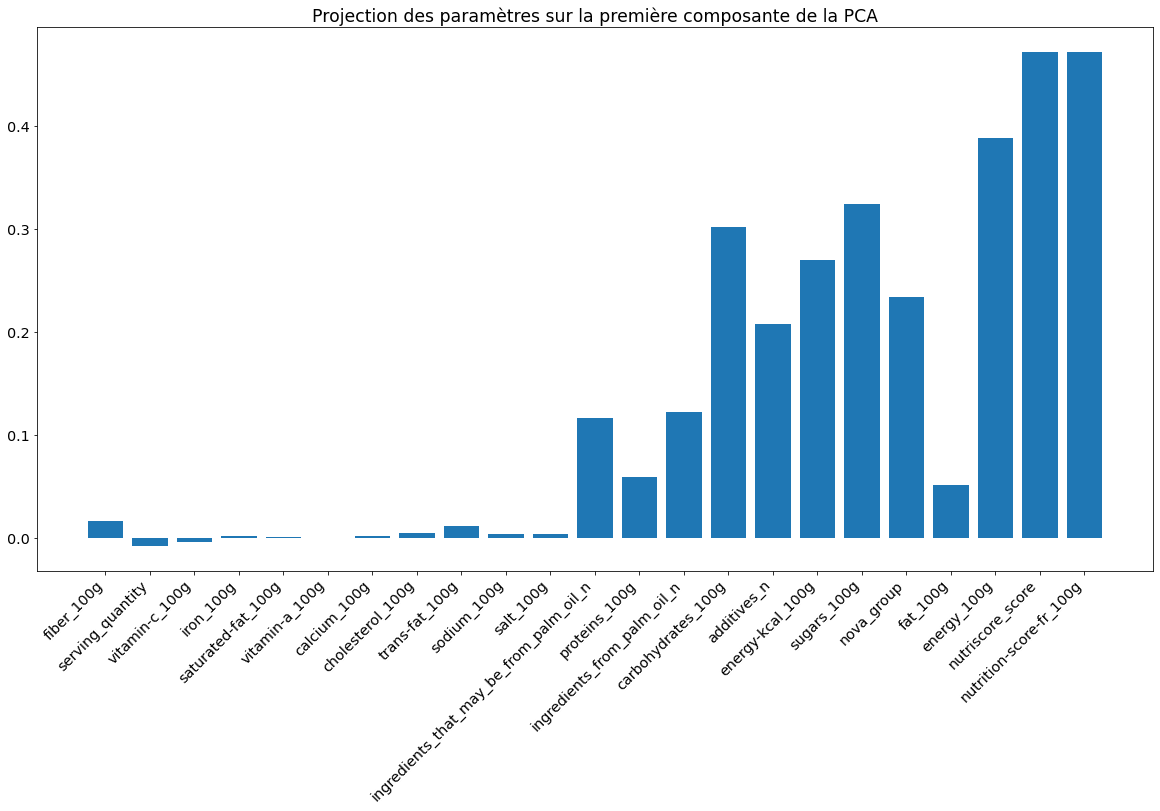

In [60]:
plt.figure(figsize=(20,10))
plt.bar(features, pcs[0,:])
plt.xticks(rotation=45, ha='right')
plt.title('Projection des paramètres sur la première composante de la PCA')

Plusieurs chose in téressante ressote de cette étude:
- les quantités de fibres aux 100g sont le paramètres le plus en inverse de phase avec le nutriscore. 
    Cela semble logique, le nutriscore est inversement proportionnel à la qualité nutritionnelle du produit 
    ( bon produit => score faible). Fibres présentes dans les aliments "sains" fruits, légumes...
- le cholesterol semble très peu corrélé au nutriscore, assez contrintuitif
- la qté de sucre, le nova_group, le gras et l'énergie sont les plus corrélé avec le nutriscore, assez intuitif

Particulièrement intéressant pour le nova_score, qui est le degré de transofrmation d'un produit avec:
- 1 : les produits peu ou non transformés
- 2 : les produits culianires
- 3 : "         "  transormés
- 4 : "         "  ultra-transformés


In [61]:
nova_set = (cat_explode.dropna(subset=['nova_group', 'nutriscore_score']))

In [62]:
len(nova_set.nutriscore_score)

1690633

In [63]:
len(nova_set.nova_group)

1690633

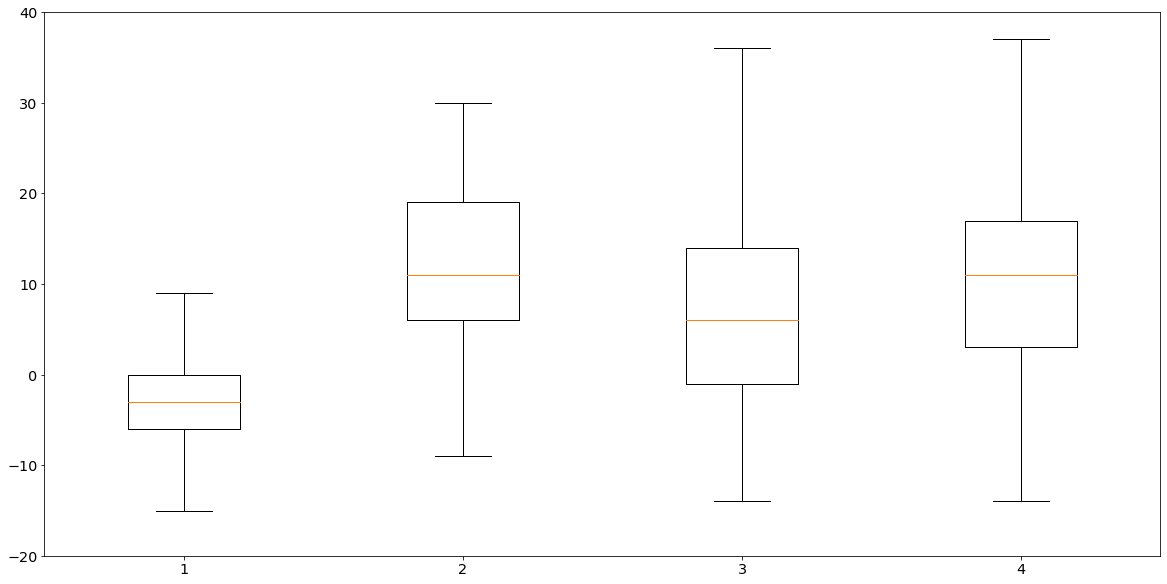

In [64]:
import pylab

BoxName = ['Non transformés','Peu tranformés','Transformés', 'Ultra transformés']

data = [nova_set[nova_set.nova_group == nova_cat]['nutriscore_score'] for nova_cat in np.sort(nova_set.nova_group.unique())]

plt.boxplot(data,
            showfliers= False, # on ne prend pas en compte les outliers
            widths= 0.4, # largeur graphique des boxplots
           )

plt.ylim(-20,40)


plt.show()

In [65]:
data = [list(nova_set[nova_set.nova_group == nova_cat]['nutriscore_score']) for nova_cat in np.sort(nova_set.nova_group.unique())]

Text(0, 0.5, 'Nutriscore')

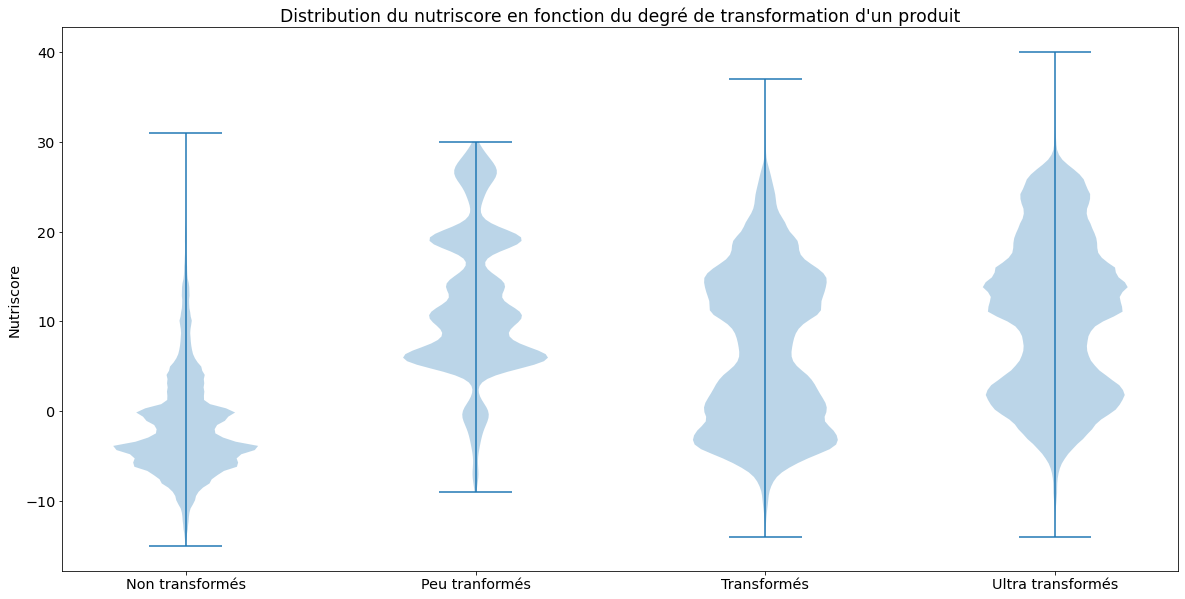

In [66]:
# violon plot
plt.figure()
plt.violinplot(data)
plt.title('Distribution du nutriscore en fonction du degré de transformation d\'un produit')
pylab.xticks([1,2,3,4], BoxName)
plt.ylabel('Nutriscore')

On observe une relation assez linéaire pour les produits Non transformés, Transformés et Ultra transformés.
Plus le produit est transformé, plus le nutriscore se dégrade.
En revanche, on observe un résultat étonnament haut pour le nutriscore des produits Peu transformés.

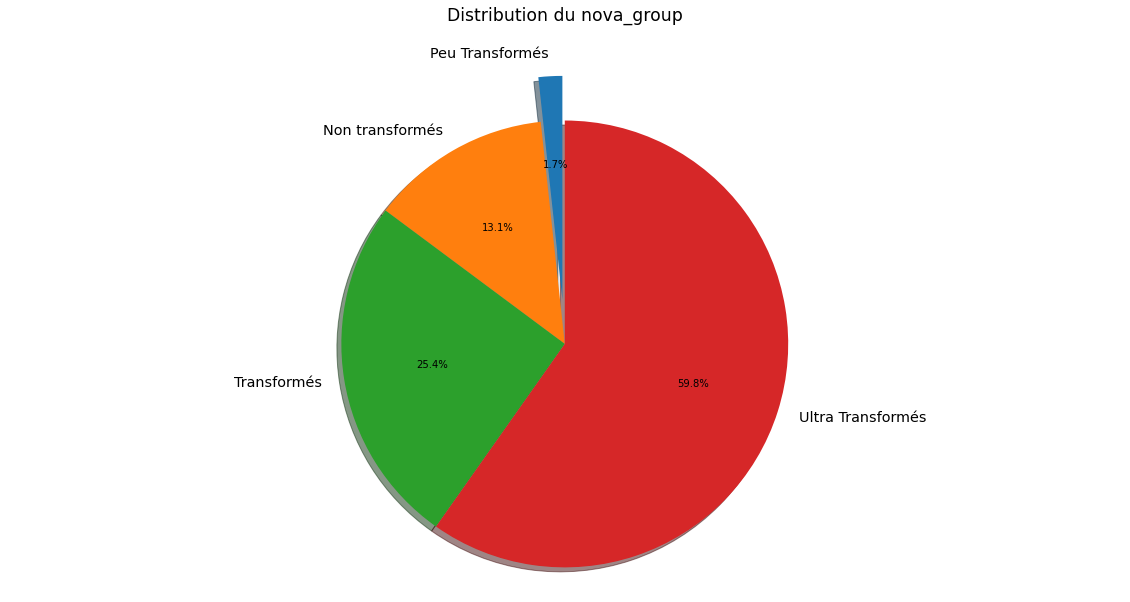

In [67]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['Peu Transformés', 'Non transformés', 'Transformés', 'Ultra Transformés']
sizes = list(nova_set['nova_group'].value_counts().sort_values())
explode = (0.2, 0., 0., 0.)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Distribution du nova_group', pad=30)

plt.show()

On observe que la catégorie Peu Transformé comprend en réalité peu d'échantillons comparée aux autres.
Les résultats sont donc probablement moins représentatifs.

# Analyse ANOVA

On peut appliquer l'étude du nutri_score sur de nombreuses catégories de produits et dans différents pays pour identifier les
habitudes alimentaires des différents pays. On pourrait ainsi essayer de lier ces habitudes avec des pathologies comme l'obésité
et entraîner un modèle pour déceler les liens de causalité entre les habitudes alimentaires et certaines maladies.

In [69]:
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

In [70]:
anova_score = eta_squared(nova_set.nova_group, nova_set.nutriscore_score)

In [71]:
print('Corrélation entre le nutriscore et le nova groupe : ', anova_score)

Corrélation entre le nutriscore et le nova groupe :  0.20050839336289103


Il existe bel et bien une corrélation entre le degré de transformation d'un produit et son nutriscore.